In [1]:
from typing import Union, Callable

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
from tqdm import tqdm

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model, load_models_with_scalers_with_prefix
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
from lib.voting import perform_weighted_voting
from lib.confusion_matrix import display_confmat
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

In [2]:
tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cpu')

# Challenge

In [3]:
challenge_data = load_challenge_data()
challenge_data.shape

(16, 3000, 548)

In [4]:
species_models_with_scalers_and_scores = load_models_with_scalers_with_prefix('saved_models', 'species_classifier')       
print(len(species_models_with_scalers_and_scores))

species_classifier full2023-06-19_02.00: eval_score None!
species_classifier full2023-06-19_02.00: test_score None!
1


In [5]:
def predict_species():
    predictions_list: list[np.ndarray] = []
    
    for model, normalization_scaler, score in tqdm(species_models_with_scalers_and_scores):
        predictions_list.append(
            predict_for_challenge(challenge_data.reshape(-1, 300, 548), model, normalization_scaler, device).reshape(16, 3000)
        )
    return np.moveaxis(np.array(predictions_list), 0, -1)

species_predictions = predict_species()
species_predictions.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


(16, 3000, 1)

In [ ]:
bird_no_bird_models_with_scalers_and_scores = load_models_with_scalers_with_prefix('saved_models/2023-06-15/bird_no_bird_classifier', 'bird_no_bird_classifier')
print(len(bird_no_bird_models_with_scalers_and_scores))

In [11]:
def predict_bird_no_bird():
    predictions_list: list[np.ndarray] = []
    for model, normalization_scaler, score in tqdm(bird_no_bird_models_with_scalers_and_scores):
        predictions_list.append(
            predict_for_challenge(challenge_data, model, normalization_scaler, device)
        )
    return np.moveaxis(np.array(predictions_list), 0, -1)

bird_no_bird_predictions = predict_bird_no_bird()
bird_no_bird_predictions.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.06it/s]


(16, 3000, 16)

In [15]:
def calc_scores(models_with_scalers_and_scores) -> np.ndarray:
    return np.array([
        (eval_score + test_score) / 2
        for _, _, (eval_score, test_score) 
        in models_with_scalers_and_scores
    ])

def get_weights(models_with_scalers_and_scores, non_linearity_exponent):
    weights = calc_scores(models_with_scalers_and_scores)
    
    if len(weights) <= 1:
        raise ValueError('nono')
        
    if len(weights) > 1:
        weights -= np.min(weights)
        weights /= np.max(weights)
        weights **= non_linearity_exponent
        weights /= weights.sum()
    return weights
    

In [72]:
species_weights = get_weights(species_models_with_scalers_and_scores, 0.66)
bird_no_bird_weights = get_weights(bird_no_bird_models_with_scalers_and_scores, 0.66)

print(f'species_scores       = {", ".join([f"{w:.4f}" for w in calc_scores(species_models_with_scalers_and_scores)])}')
print(f'species_weights      = {", ".join([f"{w:.4f}" for w in species_weights])}')
print()
print(f'bird_no_bird_scores  = {", ".join([f"{w:.4f}" for w in calc_scores(bird_no_bird_models_with_scalers_and_scores)])}')
print(f'bird_no_bird_weights = {", ".join([f"{w:.4f}" for w in bird_no_bird_weights])}\n')

species_weights_modifier = 1.0
bird_no_bird_weights_modifier = 0.5

print(f'species_weights (modified)      = {", ".join([f"{w:.4f}" for w in (species_weights * species_weights_modifier)])}')
print(f'bird_no_bird_weights (modified) = {", ".join([f"{w:.4f}" for w in (bird_no_bird_weights * bird_no_bird_weights_modifier)])}\n')

voting_results = perform_weighted_voting(
    species_predictions=species_predictions,
    species_classifier_voting_weights=species_weights * species_weights_modifier,
    bird_no_bird_predictions=bird_no_bird_predictions,
    bird_no_bird_classifier_voting_weights=bird_no_bird_weights * bird_no_bird_weights_modifier,
)
voting_results

species_scores       = 0.8198, 0.8366, 0.8331, 0.8056, 0.8172, 0.7963, 0.8301, 0.8181, 0.7932, 0.7957, 0.8229, 0.7964, 0.7958, 0.8095, 0.8309, 0.8303, 0.8041, 0.8255, 0.8194, 0.8303, 0.8246, 0.8326, 0.8213, 0.8100, 0.8114, 0.8121
species_weights      = 0.0447, 0.0618, 0.0585, 0.0272, 0.0418, 0.0109, 0.0555, 0.0428, 0.0000, 0.0096, 0.0481, 0.0112, 0.0098, 0.0323, 0.0563, 0.0558, 0.0250, 0.0509, 0.0443, 0.0557, 0.0499, 0.0580, 0.0464, 0.0331, 0.0348, 0.0358

bird_no_bird_scores  = 0.8213, 0.8200, 0.8433, 0.8257, 0.8328, 0.8357, 0.8282, 0.8314, 0.8144, 0.8327, 0.8357, 0.8277, 0.8124, 0.8290, 0.8468, 0.8274
bird_no_bird_weights = 0.0435, 0.0393, 0.0988, 0.0569, 0.0753, 0.0820, 0.0637, 0.0718, 0.0162, 0.0749, 0.0821, 0.0623, 0.0000, 0.0657, 0.1061, 0.0613

species_weights (modified)      = 0.0447, 0.0618, 0.0585, 0.0272, 0.0418, 0.0109, 0.0555, 0.0428, 0.0000, 0.0096, 0.0481, 0.0112, 0.0098, 0.0323, 0.0563, 0.0558, 0.0250, 0.0509, 0.0443, 0.0557, 0.0499, 0.0580, 0.0464, 0.0331, 0.0348, 0.03

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
# saved_predictions = load_results_from_csv('submissions/challenge_submission.csv')

fixed_labels = fix_labels_information_gain(
    labels=species_predictions.squeeze(),#voting_results, 
    window_size=30, 
    window_overlap=9, 
    splitting_point_window_shrink=5,
    split_at_0_only=True,
    information_gain_threshold=0.1,
)

Fixing label sequences: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.14it/s]

Skipped 1408 out of 2262 windows


In [7]:
from collections import Counter

def print_label_count(labels: np.ndarray):
    counter = Counter(labels.reshape((-1)).tolist())
    
    total = sum(counter.values())
    
    for key in counter.keys():
        counter[key] /= total
    
    items = sorted(counter.items(), key=lambda item: item[0])
    
    print([f'{int(item[0])}: {item[1]:.4f}' for item in items])

In [8]:
print_label_count(fixed_labels)

['0: 0.6866', '1: 0.0778', '2: 0.0663', '3: 0.0349', '4: 0.0154', '5: 0.0623', '6: 0.0567']


In [59]:
print_label_count(load_results_from_csv('submissions/challenge_submission_2023-06-10_17.00 score=10460.csv'))

['0: 0.6780', '1: 0.0558', '2: 0.0681', '3: 0.0552', '4: 0.0223', '5: 0.0620', '6: 0.0586']


In [60]:
print_label_count(load_results_from_csv('submissions/challenge_submission_original_ac_fixed score=11124.csv'))

['0: 0.6216', '1: 0.0763', '2: 0.0789', '3: 0.0522', '4: 0.0285', '5: 0.0729', '6: 0.0696']


In [61]:
print_label_count(load_results_from_csv('submissions/bob.csv'))

['0: 0.6666', '1: 0.0811', '2: 0.0742', '3: 0.0369', '4: 0.0214', '5: 0.0650', '6: 0.0548']


In [10]:
save_results_to_csv(fixed_labels, 'submissions/challenge_submission_2023-06-19_02.00 score=TBD.csv')

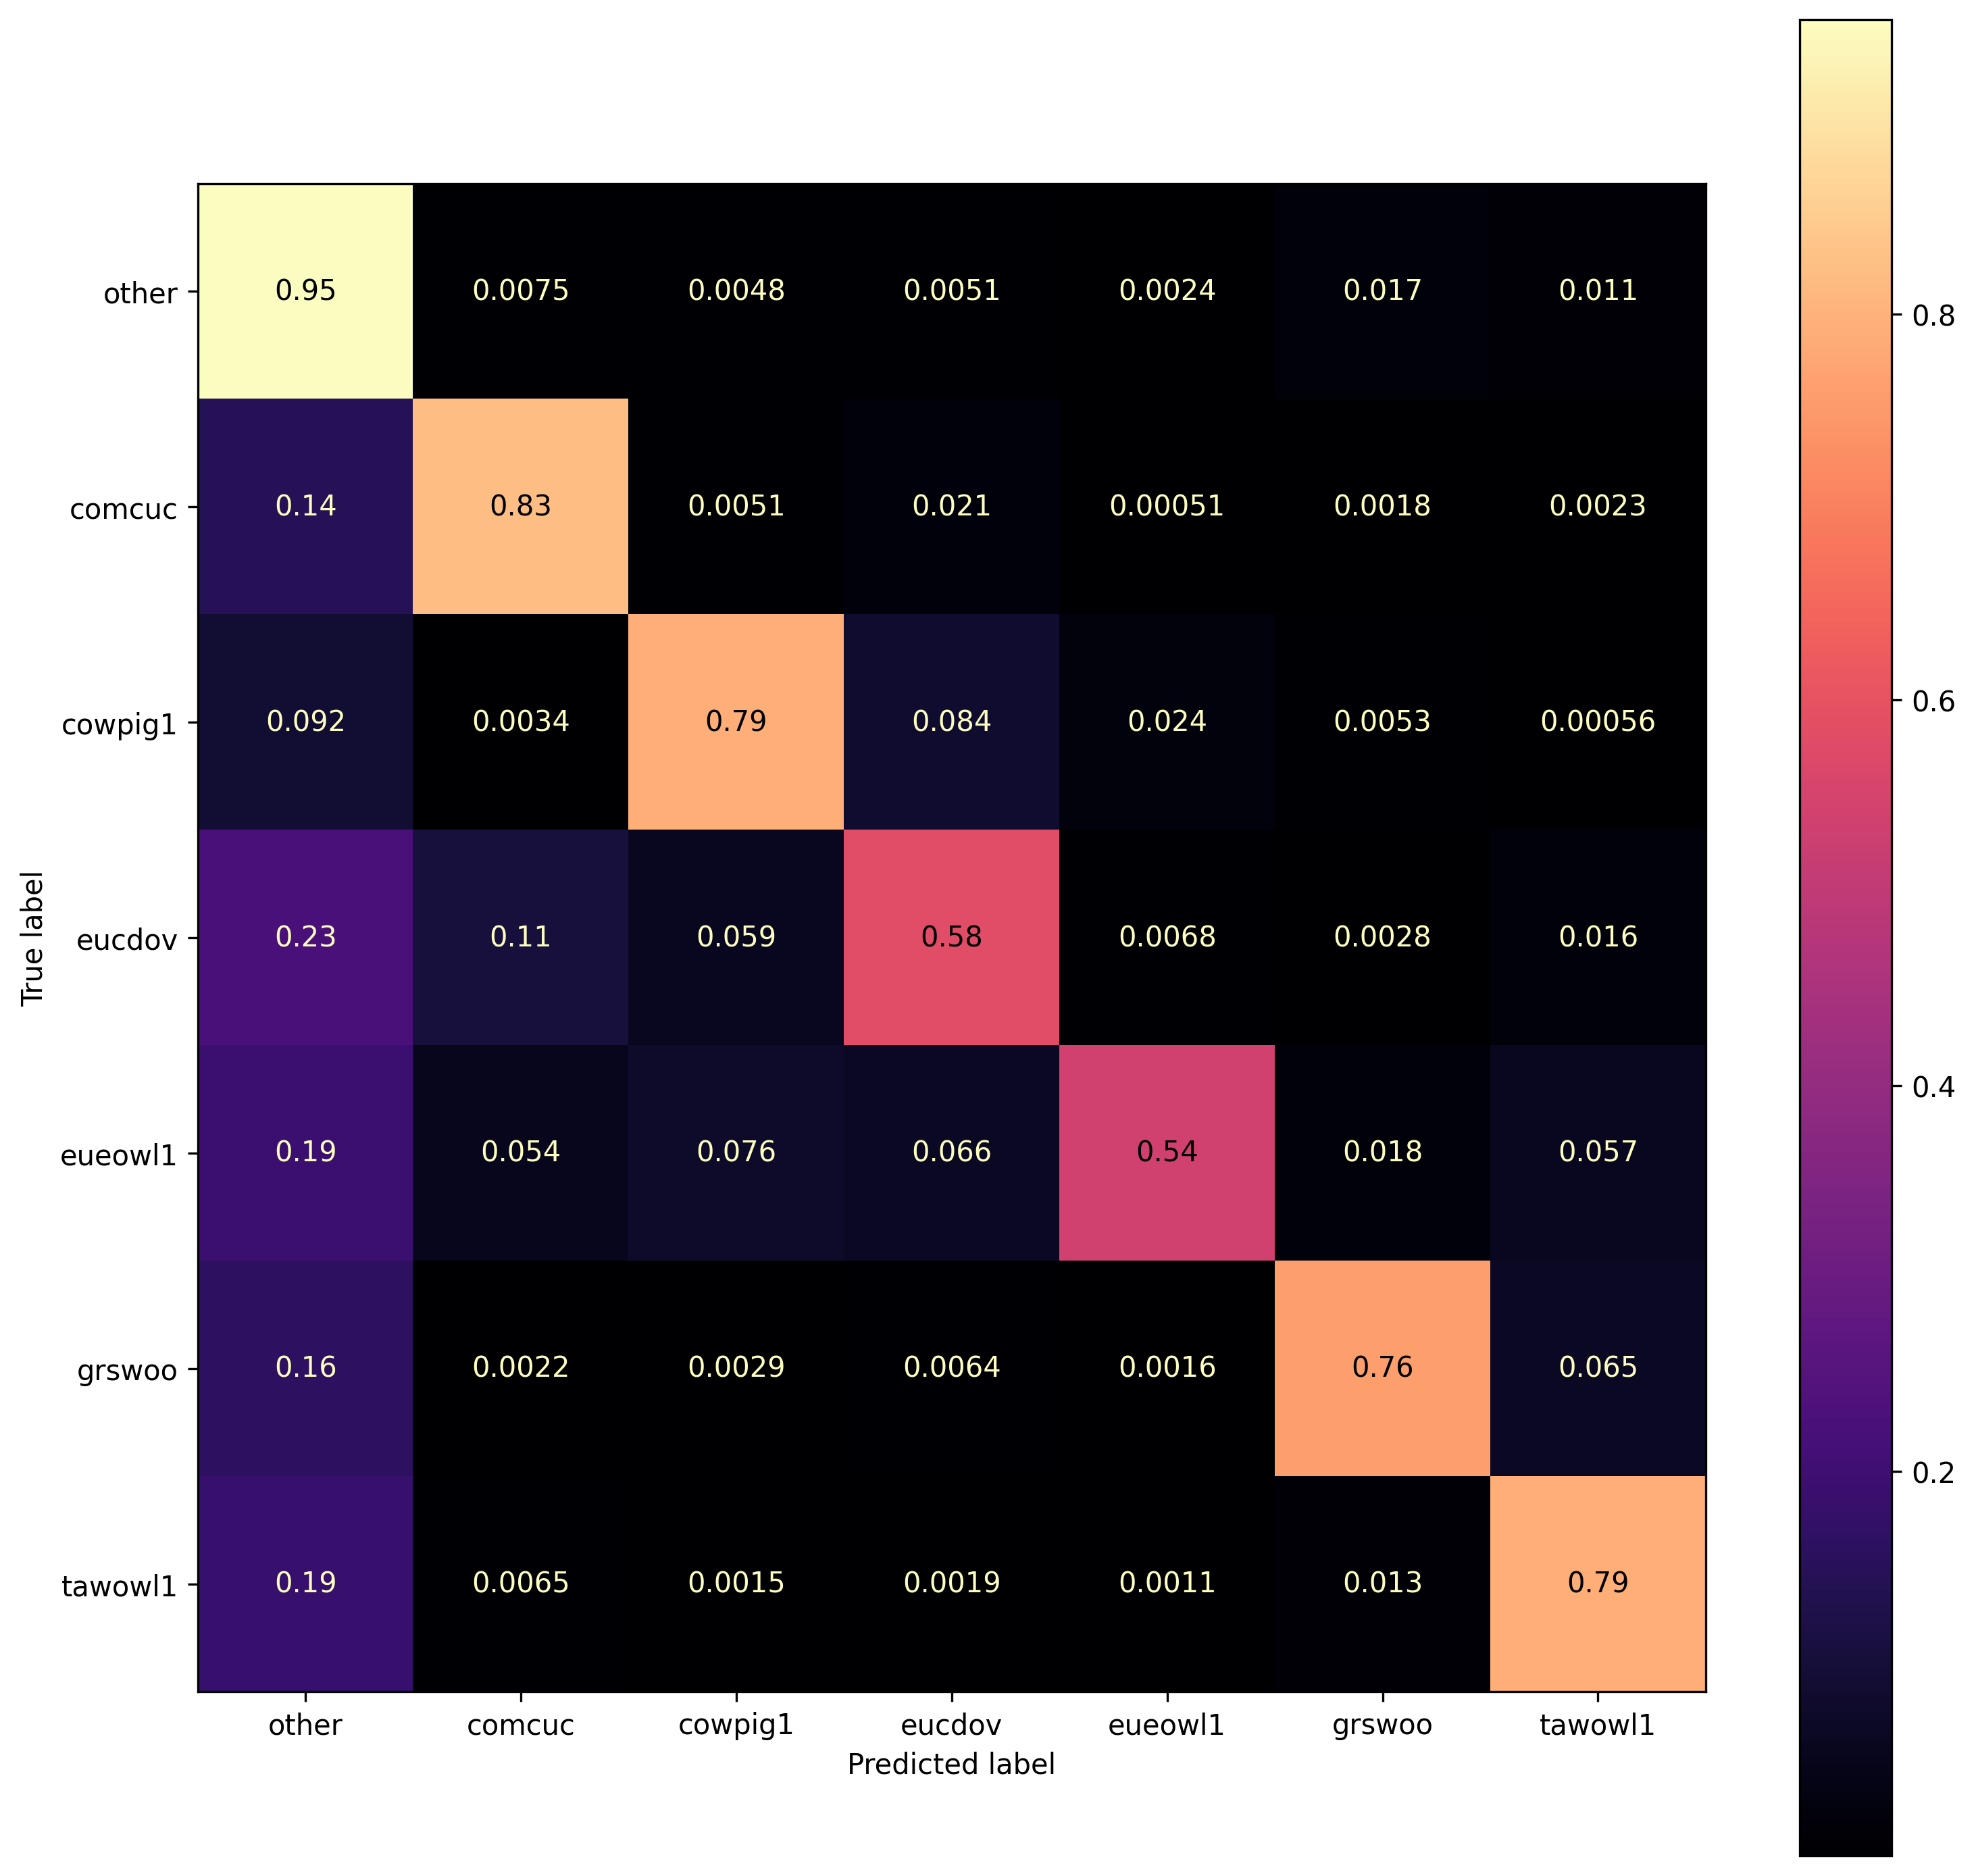

sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 6.0, sub_us[i, j] = 0
sub_bob[i, j] = 6.0, sub_us[i, j] = 0
sub_bob[i, j] = 0.0, sub_us[i, j] = 6
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j

In [11]:
sub_bob = load_results_from_csv('submissions/bob.csv')
sub_us = fixed_labels # load_results_from_csv('submissions/challenge_submission_2023-06-15_15.45 score=10209.csv')

display_confmat(sub_us.flatten(), sub_bob.flatten())

for i in range(16):
    for j in range(len(sub_bob[i])):
        if sub_bob[i, j] != sub_us[i, j]:
            print(f'{sub_bob[i, j] = }, {sub_us[i, j] = }')
    print()
    

species_classifier full2023-06-16_18.00: eval_score None!
species_classifier full2023-06-16_18.00: test_score None!
1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


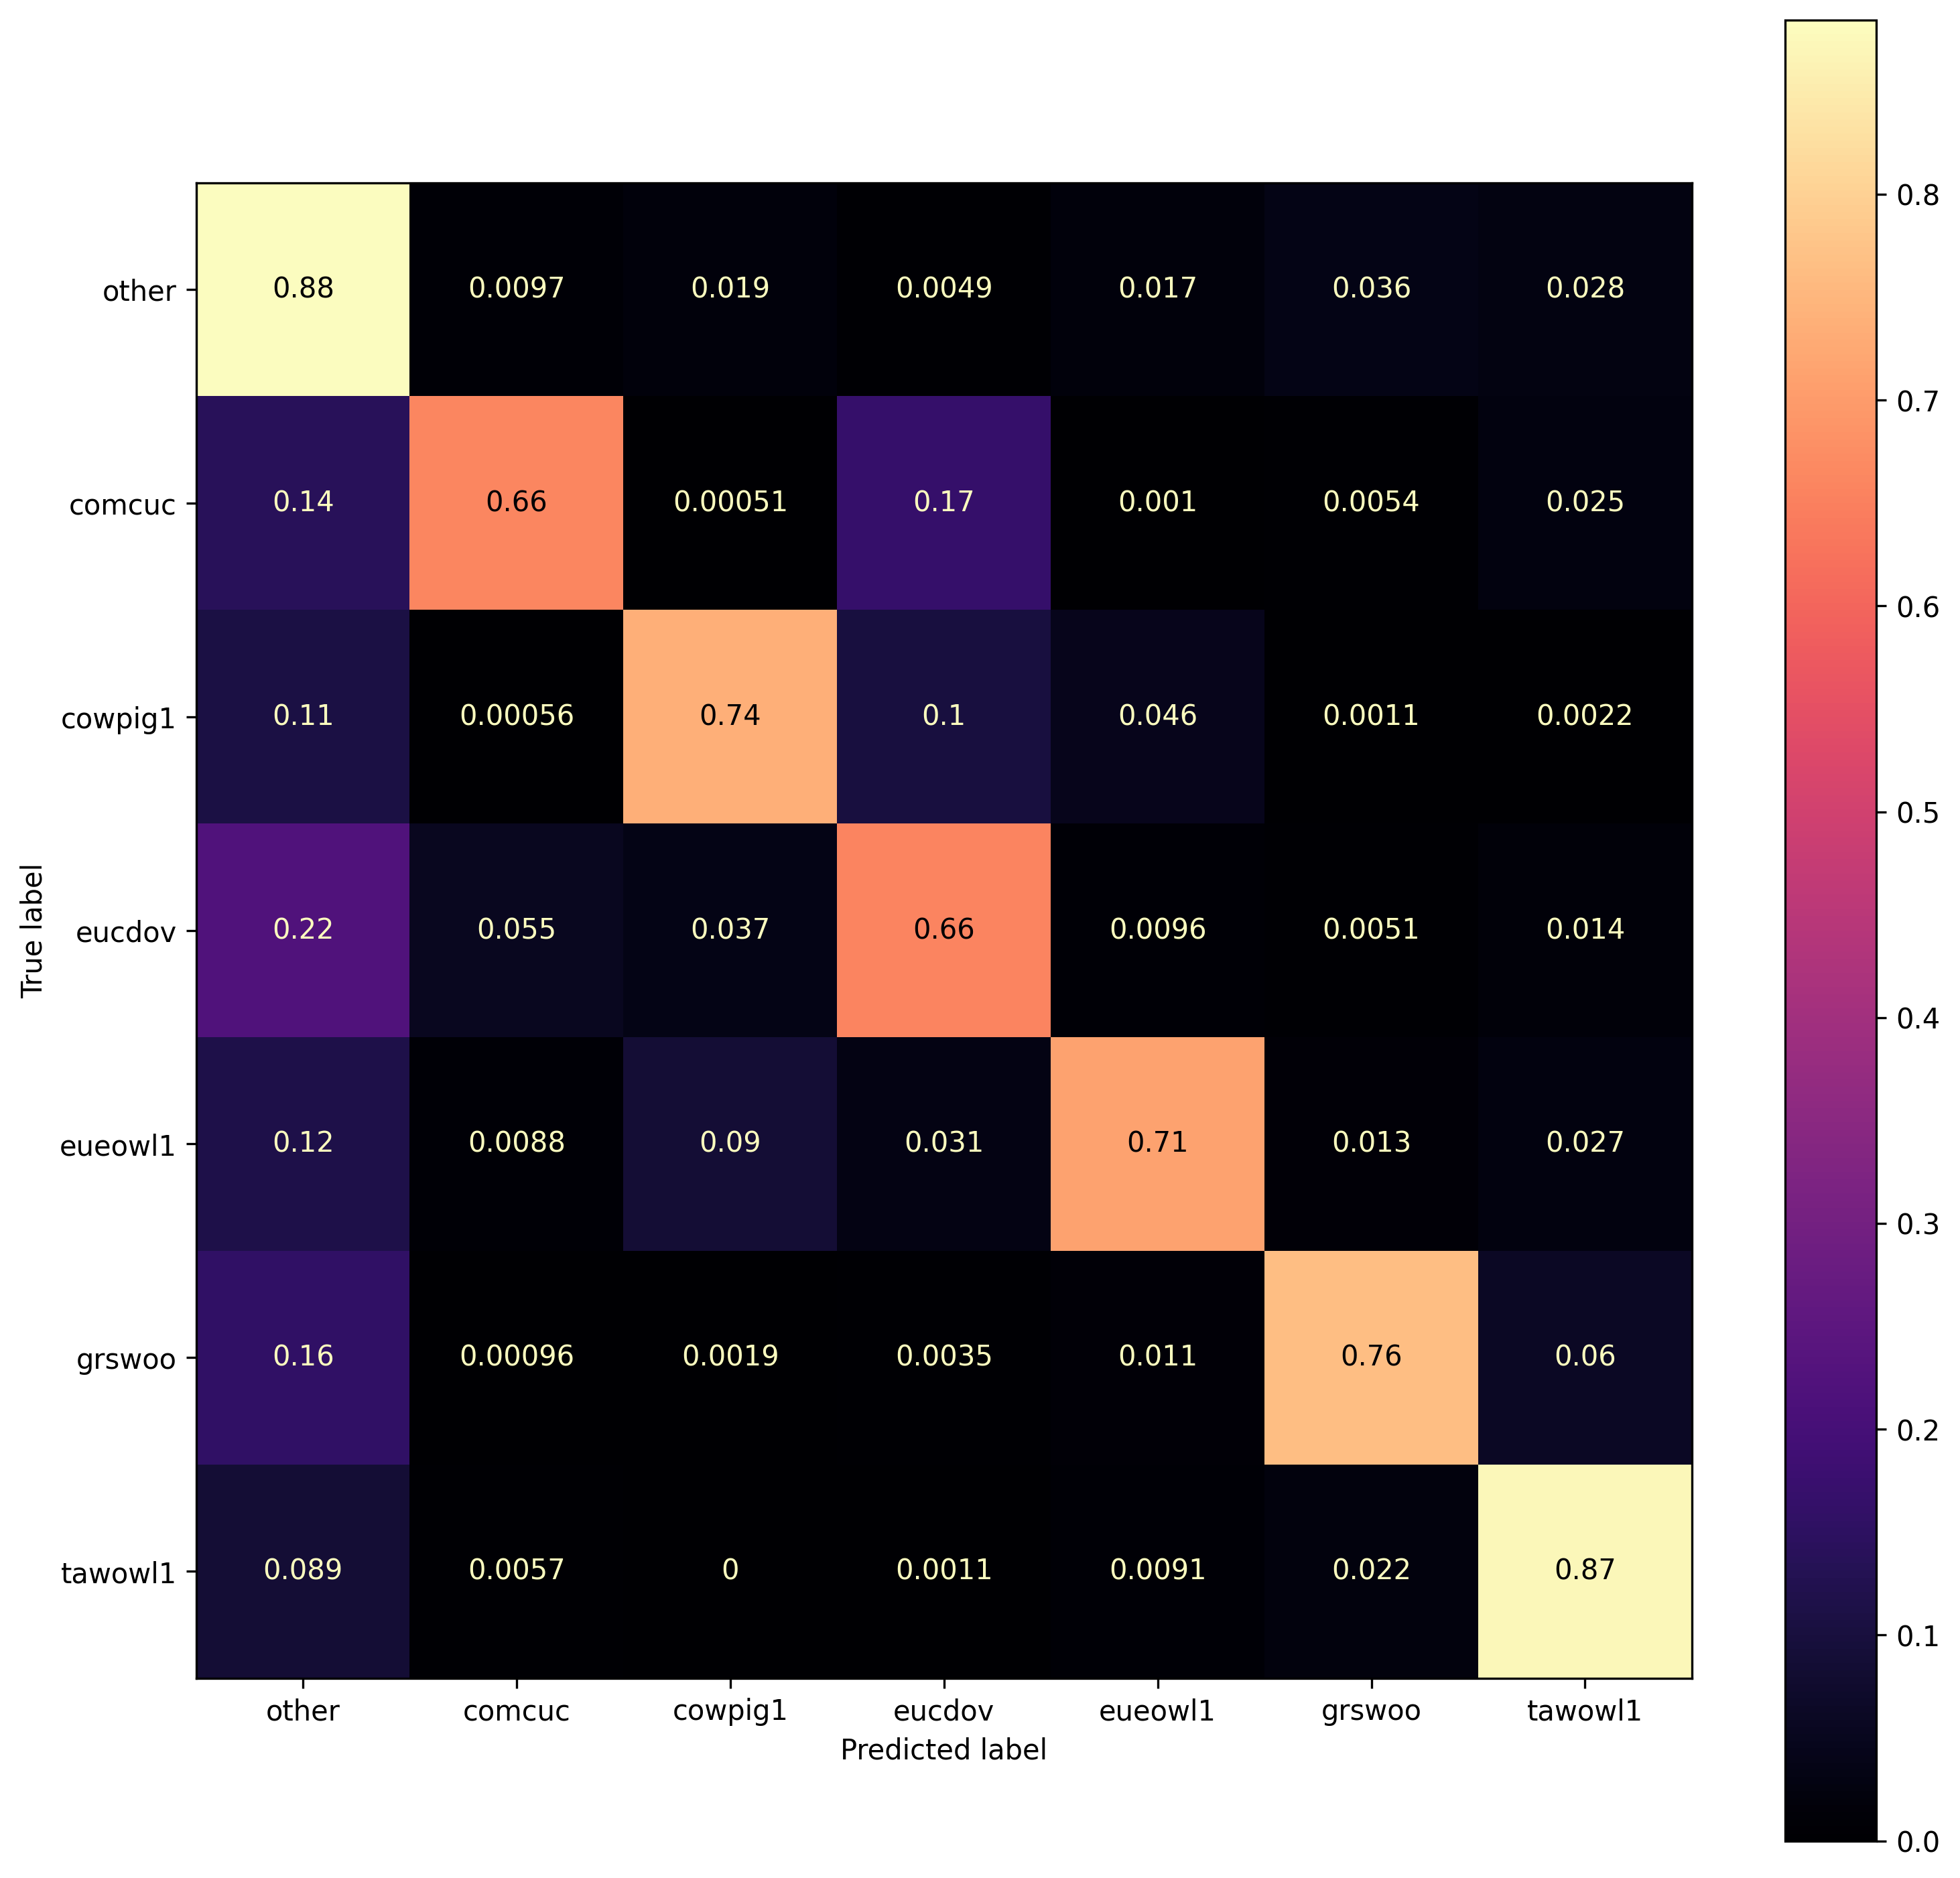

sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 0.0, sub_us[i, j] = 5
sub_bob[i, j] = 6.0, sub_us[i, j] = 5
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 1.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j] = 5.0, sub_us[i, j] = 0
sub_bob[i, j

In [66]:
species_models_with_scalers_and_scores = load_models_with_scalers_with_prefix('saved_models', 'species_classifier full2023-06-16_18.00')       
print(len(species_models_with_scalers_and_scores))

def predict_species():
    predictions_list: list[np.ndarray] = []
    for model, normalization_scaler, score in tqdm(species_models_with_scalers_and_scores):
        predictions_list.append(
            predict_for_challenge(challenge_data, model, normalization_scaler, device)
        )
    return np.moveaxis(np.array(predictions_list), 0, -1)

species_predictions = predict_species()
species_predictions.shape
fixed_labels = species_predictions.squeeze()

sub_bob = load_results_from_csv('submissions/bob.csv')
sub_us = fixed_labels # load_results_from_csv('submissions/challenge_submission_2023-06-15_15.45 score=10209.csv')

display_confmat(sub_us.flatten(), sub_bob.flatten())

for i in range(16):
    for j in range(len(sub_bob[i])):
        if sub_bob[i, j] != sub_us[i, j]:
            print(f'{sub_bob[i, j] = }, {sub_us[i, j] = }')
    print()
    